In [28]:
from datasets.load import load_images, load_annotations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle
import cv2
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 12.) # set default size of plots

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
plt.rcParams['figure.figsize'] = (15., 12.) # set default size of plots

# Configuration
please ony change the parameters provided here.

In [55]:
MODEL_DIR = 'cache'      # directory to save trained model

DATASET_DIR = 'datasets' # directory to the dataset provided in pascal VOC format
DATASET = 'train'         # train on train or all datasets

SIZE = 128                # pixel size of the training window
NUM_NEG_SAMPLES = 15000   # proportion of training to testing negative samples
TRAIN_TEST_SPLIT = .9     # approximate number of random negative samples to generate

## assertions to make sure entered values are correct
assert TRAIN_TEST_SPLIT > 0 and TRAIN_TEST_SPLIT < 1
assert SIZE == 128
assert DATASET in ['train', 'all']

## Positive Samples
### Save positive samples to disk
also showing some of the positive samples cropped to $(SIZE \cdot SIZE)$ px, as the classifier can only detect rectangular windows

In [31]:
# read training dataset
classes = load_annotations('train', DATASET_DIR, size=SIZE)

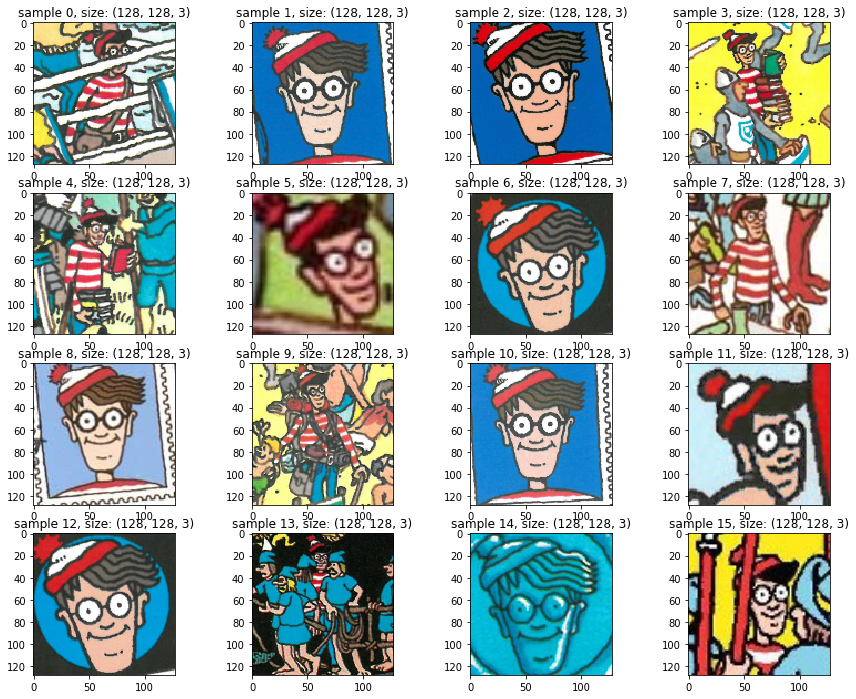

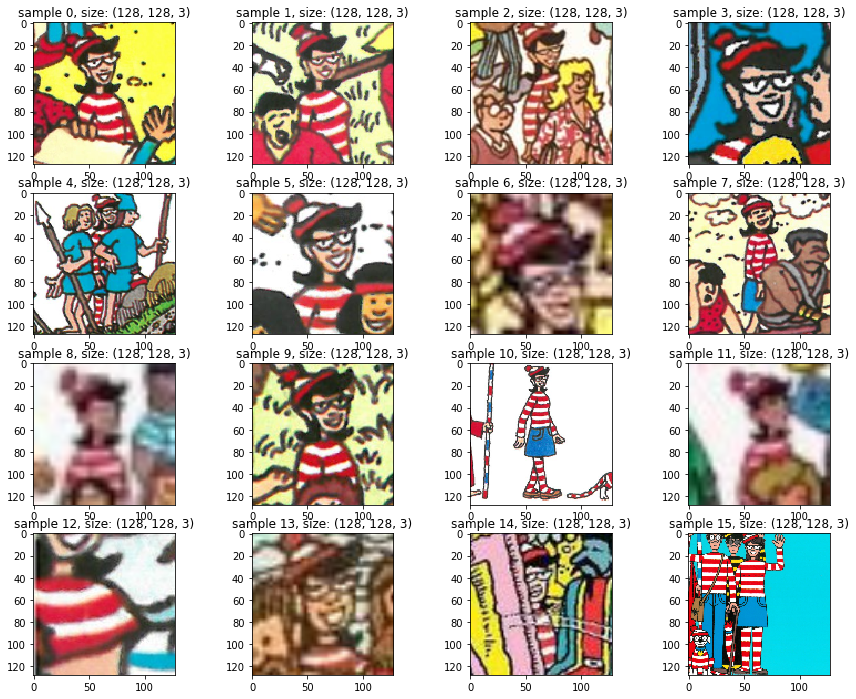

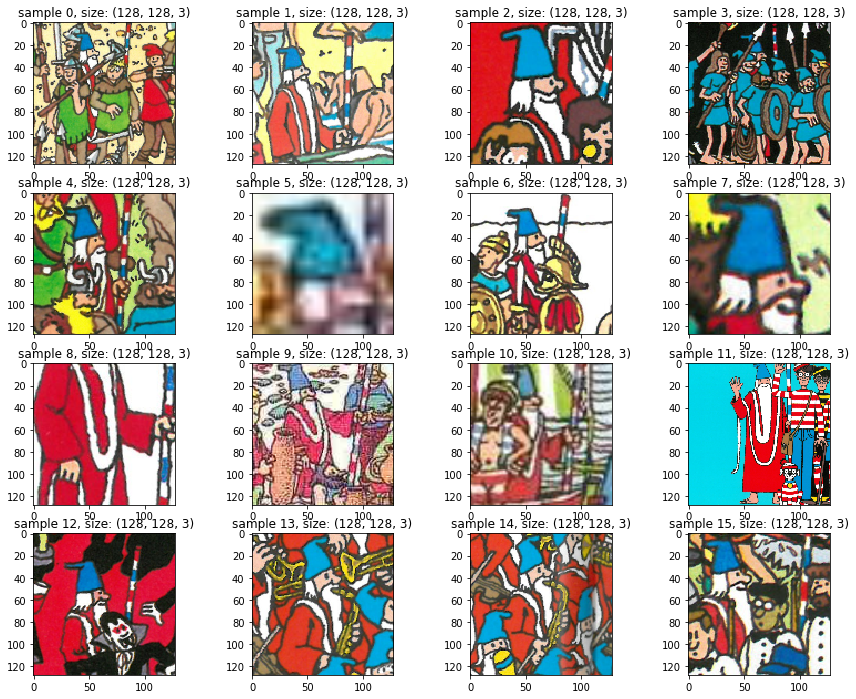

In [42]:
for cl in classes.values():
    for idx, sample in enumerate(cl[:16]):
        ax = plt.subplot(4,4,idx +1)
        plt.imshow(sample)
        plt.title('sample {}, size: {}'.format(idx, sample.shape))
    plt.show()

### Preprocessing samples
Samples are preprocessed by using kmeans to quantize all colors present in the images to only (red, blue, white, other), as these represent the waldo, wenda and wizard classes better. Also this removes noise in the feature representation of each sample.

We also use this process to transform the color images to a grayscale only version.

Predicted cluster centers:
[[253.98934503 253.69680351 253.49717957]
 [ 76.54963358  66.29513658  65.43371086]
 [182.58123953 159.22445561 154.71859296]
 [193.57440166  37.00416233  55.00520291]
 [ 28.36541889 122.20677362 190.36720143]]


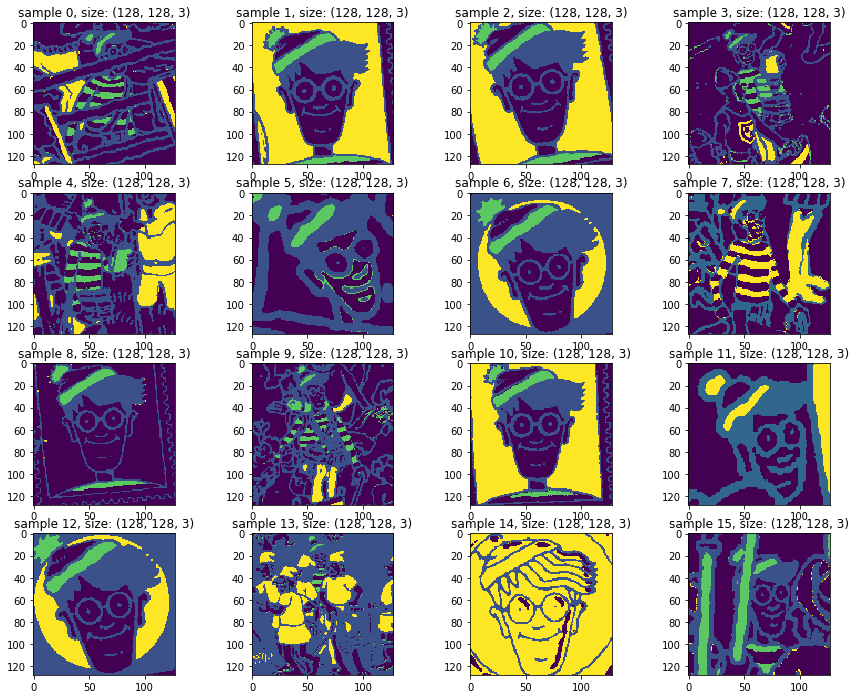

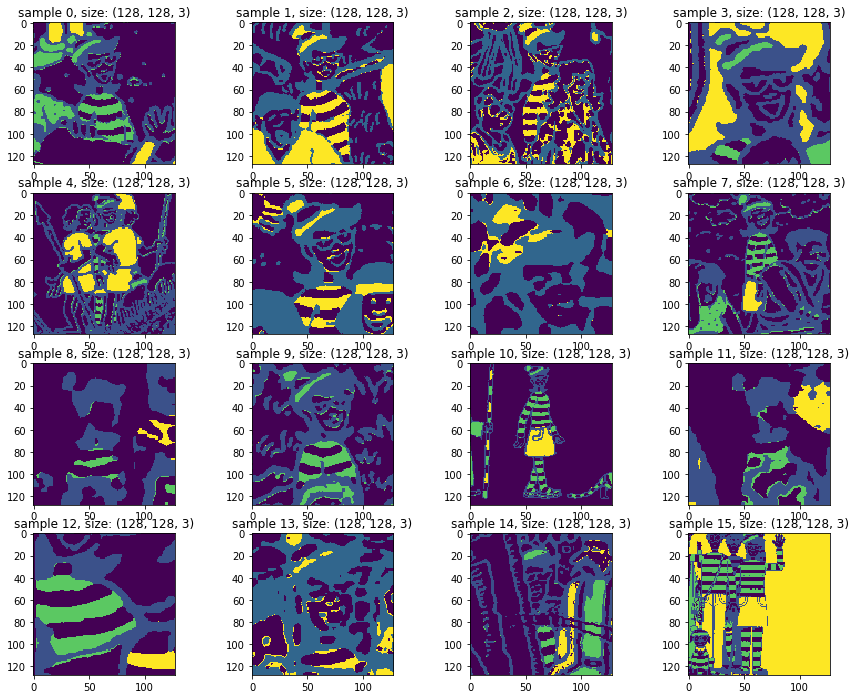

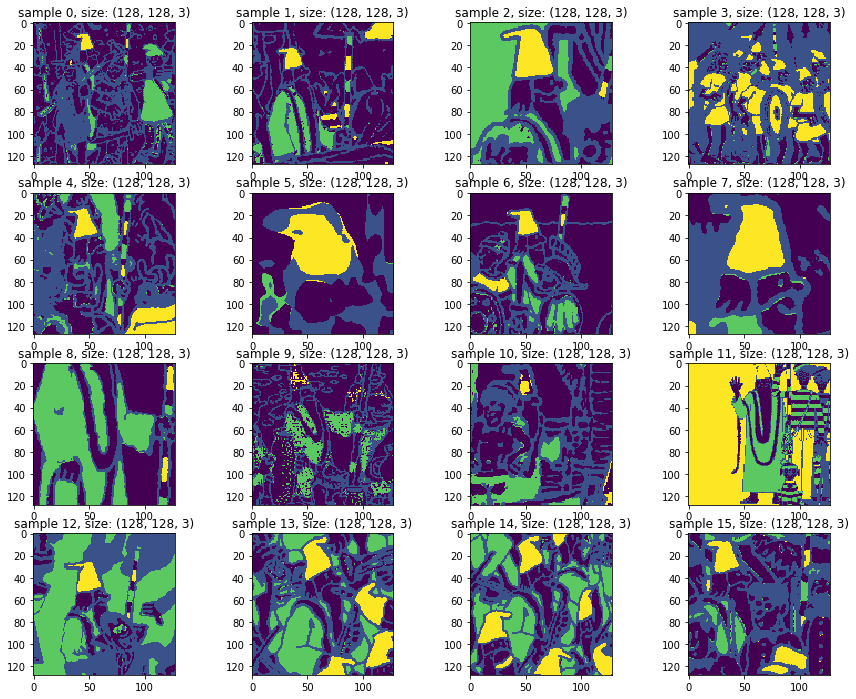

In [43]:
from sklearn.cluster import KMeans

# use wenda 10 as the reference image
img = classes['wenda'][10]
w, h, d = img.shape
# modes to find in the image (one mode will get merged with white)
K = 5

img_array = np.reshape(img, (w*h, d))
kmeans = KMeans(n_clusters = K, random_state=0).fit(img_array)
labels = kmeans.predict(img_array)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d), dtype=np.uint8)
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i,j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

def process_img(img):
    w,h,d = img.shape
    labels = kmeans.predict(np.reshape(img, (w*h,d)))
    
    white_idx =  np.argmin([np.linalg.norm(np.array([253, 253, 253]) - c) for c in kmeans.cluster_centers_])
    other_col_idx = np.argmin([np.linalg.norm(np.array([182,159,154]) - c) for c in kmeans.cluster_centers_])
    labels[labels == other_col_idx] = white_idx
    
    c = (np.arange(0,K) * 255 / (K-1)).astype(np.uint8)[np.newaxis].T
    cluster_centers = np.hstack([c,c,c])
    return recreate_image(cluster_centers, labels, w,h)[:,:,0]

print('Predicted cluster centers:')
print(kmeans.cluster_centers_)

for cl in classes.values():
    for idx, sample in enumerate(cl[:16]):
        ax = plt.subplot(4,4,idx +1)
        plt.imshow(process_img(sample))
        plt.title('sample {}, size: {}'.format(idx, sample.shape))
    plt.show()

with open(os.path.join(MODEL_DIR, "KMeans.pkl"), 'wb') as f:
    pickle.dump(kmeans, f)


### Process all samples with kemans and save them to disk

In [44]:
# write classes to .pkl files
import pickle
import os

def save_classes(classes, p, suffix, pre=(lambda x: x)):
    for name, imgs in classes.items():
        path = os.path.join(p, '{}_{}.pkl'.format(name, suffix))
        imgs = np.array([pre(x) for x in imgs])
        with open(path, 'wb') as f:
            pickle.dump(imgs, f)
        print('wrote class: {} with {} samples to {}'.format(name, imgs.shape[0], path)) 


In [45]:
# read testing dataset
classes_test = load_annotations('val', DATASET_DIR, size=SIZE)

In [47]:
if DATASET == 'all':
    classes_merged = dict()
    for name, imgs in classes.items():
        classes_merged[name] = classes[name] + classes_test[name]
    classes = classes_merged

In [48]:
save_classes(classes, MODEL_DIR, 'train', pre=process_img)
save_classes(classes_test, MODEL_DIR, 'test', pre=process_img)

wrote class: waldo with 124 samples to cache/waldo_train.pkl
wrote class: wenda with 36 samples to cache/wenda_train.pkl
wrote class: wizard with 24 samples to cache/wizard_train.pkl
wrote class: wenda with 7 samples to cache/wenda_test.pkl
wrote class: waldo with 13 samples to cache/waldo_test.pkl
wrote class: wizard with 3 samples to cache/wizard_test.pkl


## Negative samples

We randomly choose differnt windows of $(SIZE \cdot SIZE)$ from the images at various scales and make sure there is no overlap with the annotated training examples, then process and save them as well.

This might take some time depending on the number of negative samples (`NUM_NEG_SAMPLES`) to generate.

In [49]:
samples = load_images('train', DATASET_DIR)

In [50]:
import pickle
import os
import cv2

## this is adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def bbx_iou(bbx1, bbx2):
    assert bbx1['x1'] < bbx1['x2']
    assert bbx1['y1'] < bbx1['y2']
    assert bbx2['x1'] < bbx2['x2']
    assert bbx2['y1'] < bbx2['y2']
    
    # determine the coordinates of the intersection rectangle
    x_left = max(bbx1['x1'], bbx2['x1'])
    y_top = max(bbx1['y1'], bbx2['y1'])
    x_right = min(bbx1['x2'], bbx2['x2'])
    y_bottom = min(bbx['y2'], bbx2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # compute the area of both AABBs
    bbx1_area = (bbx1['x2'] - bbx1['x1']) * (bbx1['y2'] - bbx1['y1'])
    bbx2_area = (bbx2['x2'] - bbx2['x1']) * (bbx2['y2'] - bbx2['y1'])
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bbx1_area + bbx2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou
    
    
neg_samples = []
for sample in samples:
    sy, sx = sample['img'].shape[:2]
    for scale in np.random.uniform(low=0.1, high=1, size=5):
        if sy*scale - SIZE <= 5 or sx*scale - SIZE <= 5:
            continue
        
        r = cv2.resize(sample['img'], dsize=(int(sx*scale), int(sy*scale)), interpolation=cv2.INTER_NEAREST)
        views = zip(np.random.randint(low=0, high=r.shape[0] - SIZE, size=NUM_NEG_SAMPLES//(len(samples) * 5)),
                   np.random.randint(low=0, high=r.shape[1] - SIZE, size=NUM_NEG_SAMPLES//(len(samples) * 5)))
        for v in views:
            # ensure there is no overlap between bounding boxes and negative sample
            bbx = {'x1':v[1], 'y1':v[0], 'x2':v[1] + SIZE, 'y2':v[0] + SIZE}
            if 0.1 > np.max([bbx_iou(bbx, b) for cl in sample['classes'] for b in cl['bounds']]):
                neg_samples.append(r[v[0]:v[0] + SIZE, v[1]:v[1] + SIZE])

# Free samples
del samples

neg_samples = np.array(neg_samples)
np.random.shuffle(neg_samples)
neg_samples = np.array([process_img(x) for x in neg_samples])
split = int(TRAIN_TEST_SPLIT * neg_samples.shape[0])

neg_train, neg_test = neg_samples[:split,:], neg_samples[split:, :]


In [51]:
with open(os.path.join(MODEL_DIR, "neg_samples_train.pkl"), 'wb') as f:
    pickle.dump(neg_train, f)
with open(os.path.join(MODEL_DIR, "neg_samples_test.pkl"), 'wb') as f:
    pickle.dump(neg_test, f)

### Display some processed negative samples

Number of generated samples: 14763


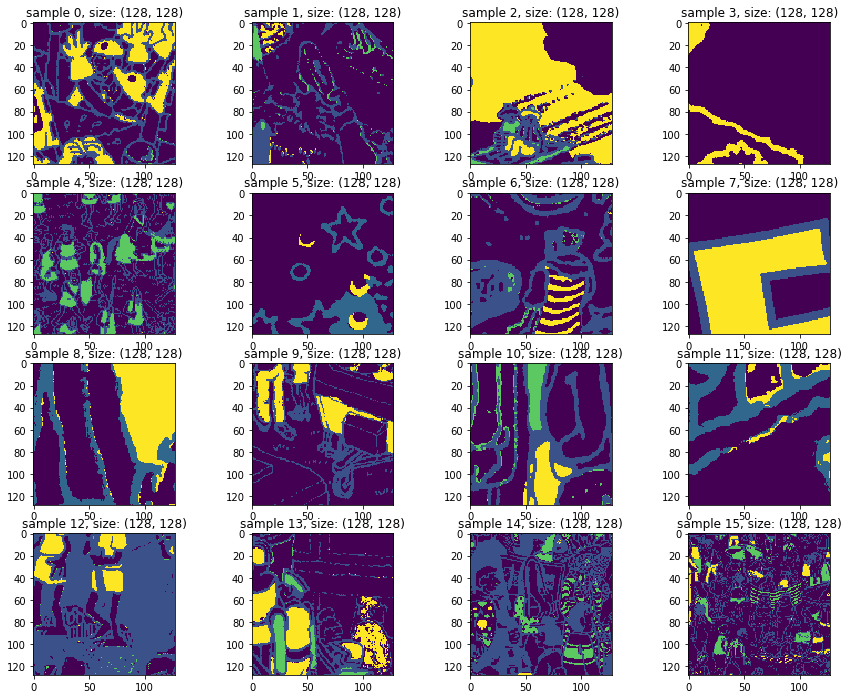

In [52]:
print('Number of generated samples: {}'.format(len(neg_samples)))
for idx, sample in enumerate(neg_train[:16]):
    ax = plt.subplot(4,4,idx +1)
    plt.imshow(sample)
    plt.title('sample {}, size: {}'.format(idx, sample.shape))

plt.show()